In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import json
import subprocess
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#
# system_name='mazama'
system_name='SERC'
groups_fname=None

#groups_fname='mazama_groups.json'
#
#data_file_name='data/sacct_mazama_out_2.out'
#data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_mazama_out_20200506a.out'
#data_file_name = 'data/sacct_serc_20200622.out'
data_file_name = 'data/sacct_serc_20200622.out'

#data_file_name = 'data/serc_sacct_2020_06_29.out'
output_path = 'output/{}_HPC_analytics'.format(system_name)
#output_path = 'output/HPC_analytics'

In [9]:
#ls data


In [11]:
load_pickle = True
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
#
if load_pickle:
    with open(pkl_name, 'rb') as fin:
        sacct_mazama=pickle.load(fin)
    #
else:
    sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name)
    #
    
    with open(pkl_name, 'wb') as fout:
            #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
            out_pkl = pickle.dump(sacct_mazama, fout)
#

In [12]:
class Tex_Slides(object):
    def __init__(self, template_json='tex_components/EARTH_Beamer_template.json',
                 Short_title='', Full_title='Title',
               author='Mark R. Yoder, Ph.D.',
               institution='Stanford University, School of Earth', institution_short='Stanford EARTH',
              email='mryoder@stanford.edu', foutname='output/HPC_analytics/HPC_analytics.tex' ):
        #
        self.__dict__.update({ky:vl for ky,vl in locals().items() if not ky in ('self', '__class__')})
        #
        # TODO: add an index. handle user content and ordering with this index. it's separate from
        #. the content dictionary; something simple like [[k, key_k]]. We can nest both in a 
        #  JSON format, so we'll load tex_template like, tex_templates=json.load(fin)['templates']
        #  ... but for now, let's not worry about order.
        #
        #
        foutnames = os.path.split(foutname)
        if not os.path.isdir(foutnames[0]):
            os.makedirs(foutnames[0])
        #
        #
        with open(template_json, 'r') as fin:
            self.tex_templates=json.load(fin)
        #self.header = self.get_header()
        #self.title = self.get_title(Short_title=Short_title, Full_title=Full_title,
        #      author=author, institution=institution, institution_short=institution_short,
        #      email=email )
        #
        # a dict/json object containing the tex components.
        self.tex_elements={'header':self.get_header(), 'title':self.get_title(Short_title=Short_title, Full_title=Full_title,
              author=author, institution=institution, institution_short=institution_short,
              email=email )}
    #
    @property
    def header(self):
        return self.tex_elements['header']
    #
    @property
    def title(self):
        return self.tex_elements['title']
    #
    #
    def get_header(self):
        return self.tex_templates['header']
    
    def get_title(self, Short_title=None, Full_title=None,
           author=None, institution=None, institution_short=None, email=None ):
        '''
        # gets title information from json file
        '''
        #
        return self.tex_templates['title'].format(Short_title=Short_title, Full_title=Full_title, author=author,
                                    institution=institution, institution_short=institution_short,
                                             email=email)
    #
    def add_fig_slide(self, fig_title='Figure', width=.8, fig_path=''):
        self.tex_elements['slide_{}'.format(len(self.tex_templates))] = self.tex_templates['figslide'].format(fig_title=fig_title, width=width, fig_path=fig_path)
        
    #
    def save_presentation(self, foutname="my_presentation.json"):
        with open(foutname, 'w') as fout:
            json.dump(fout)
        #
    #
    def render(self, foutname=None):
        if foutname is None:
            foutname=self.foutname
        #
        with open(foutname, 'w') as fout:
            fout.write(self.header)
            fout.write('\n')
            fout.write(self.title)
            #
            fout.write('\n\n\\begin{document}\n\n')
            #
            fout.write("\\begin{frame}\n\\titlepage\n\\end{frame}\n\n")
            #
            for ky,val in self.tex_elements.items():
                if ky in ('header', 'title'):
                    continue
                #
                print('** adding slide: {}'.format(ky))
                #
                fout.write("\n{}\n".format(val))
            #
            fout.write('\n\n\\end{document}\n\n')
        #
        # not working yet...
        #pdf_latex_out = subprocess.run(['pdftex', '-output-directory', output_path, foutname])
    #
    
    


In [13]:
# print(sacct_mazama.jobs_summary[0:5])
# print(sacct_mazama.jobs_summary.dtype.names)

In [14]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]))

*** max_submit: 2020-06-22 17:51:00+00:00, max_start: 2020-06-22 17:40:21+00:00


In [15]:
#
#cpu_usage = sacct_mazama.active_jobs_cpu()
cpu_usage = sacct_mazama.cpu_usage
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=None)

** DEBUG: shapes:: (1, 1222496), (1, 1222496)
** ** **: t_start, t_end:  [[737567.45162037 737567.91616898 737567.47021991 ... 737567.4587037
  737567.4587037  737567.4587037 ]] [[737567.45162037 737568.60381944 737567.48172454 ... 737567.46856481
  737567.46857639 737567.46892361]]


In [16]:
# print('** ', len(cpu_usage['time']))
# print('** ** ', sacct_mazama.data[0:5])
# print('** ', sacct_mazama.data.dtype)

[Text(737375.0, 0, '2019-11-12'),
 Text(737400.0, 0, '2019-12-7'),
 Text(737425.0, 0, '2020-1-1'),
 Text(737450.0, 0, '2020-1-26'),
 Text(737475.0, 0, '2020-2-20'),
 Text(737500.0, 0, '2020-3-16'),
 Text(737525.0, 0, '2020-4-10'),
 Text(737550.0, 0, '2020-5-5'),
 Text(737575.0, 0, '2020-5-30'),
 Text(737600.0, 0, '2020-6-24'),
 Text(737625.0, 0, '2020-7-19')]

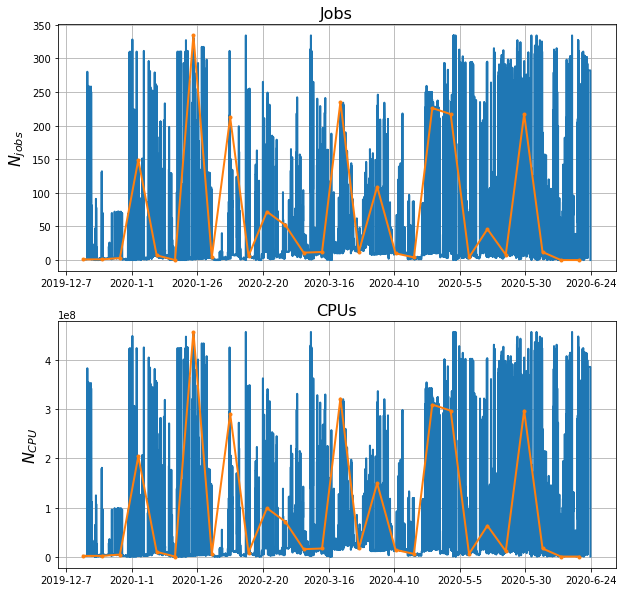

In [17]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [18]:
def time_bin_aggregates(XY, bin_mod=24, qs=[.25, .5, .75]):
    # NOTE: this is not quite general purpose. it takes the input%1, then converts the fractional remainder
    #. (modulus) to an integer(ish) by multiplying. Aka, t%1 gives the remaining fraction of a day (by standard
    #. python date conventions); (t%1)*24 gives that in hours. But to convert this to DoW, we first have 
    #. to convert the numerical date to weeks, so we'd want (t-t_0)%7, or we could use this function, but
    #. pass t=t_days/7., bin_mod=7, and really we'd want to do a phase shif to get DoW correctly.
    XY=numpy.array(XY)
    if XY.shape[0]==2:
        X = XY[0,:]
        Y = XY[1:]
    else:
        X = XY[:,0]
        Y = XY[:,1]
    #
    #X_mod = ((X*bin_mod)%bin_mod).astype(int)
    X_mod = ((X%1.)*bin_mod).astype(int)
    #
    stats_output=[]
    for x in numpy.unique(X_mod):
        ix = X_mod==x
        this_Y = Y[ix]
        stats_output += [numpy.append([x, numpy.mean(this_Y), numpy.std(this_Y)],
                                      numpy.quantile(this_Y, qs))]
    #
    # TODO: convert this to a structured array. it looks (mostly) just like a record array, but it's not...
    #.  and it's faster...
    return numpy.core.records.fromarrays(numpy.array(stats_output).T, dtype=[('x', '>f8'), ('mean', '>f8'),
                                                        ('stdev', '>f8')] + 
                                         [('q_{}'.format(q), '>f8') for q in qs])
#

    

In [19]:
def instant_usage_report(qs=[.45, .5, .55], figsize=(14,10), cpu_usage=cpu_usage):
    # DEPRICATION: moved to hpc_lib.SACCT_data_handler
    fg = plt.figure(figsize=(14,10))
    #
    ax1 = fg.add_subplot('231')
    ax2 = fg.add_subplot('232')
    ax3 = fg.add_subplot('233')
    ax4 = fg.add_subplot('234')
    ax5 = fg.add_subplot('235')
    ax6 = fg.add_subplot('236')
    axs = [ax1, ax2, ax3, ax4, ax5, ax6]
    [ax.grid() for ax in axs]
    #
    qs = [.45, .5, .55]
    qs_s = ['q_{}'.format(q) for q in qs]
    print('*** qs_s: ', qs_s)

    cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], 
                                                     cpu_usage['N_cpu']]).T, qs=qs)
    jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'],
                                                      cpu_usage['N_jobs']]).T, qs=qs)
    #
    cpu_weekly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time']/7.,
                                                     cpu_usage['N_cpu']]).T, bin_mod=7., qs=qs)
    jobs_weekly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time']/7.,
                                                      cpu_usage['N_jobs']]).T, bin_mod=7., qs=qs)
    #
    ix_pst = numpy.argsort( (jobs_hourly['x']-7)%24)
    #
    hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
    ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o', label='PST')
    ax2.plot((jobs_hourly['x']), jobs_hourly['mean'][ix_pst], ls='-', marker='o', label='UTC')
    ax3.plot(jobs_weekly['x'], jobs_weekly['q_0.5'], ls='-', marker='o', color='b')
    ax3.plot(jobs_weekly['x'], jobs_weekly['mean'], ls='--', marker='', color='b')
    ax3.fill_between(jobs_weekly['x'], jobs_weekly[qs_s[0]], jobs_weekly[qs_s[-1]],
                     alpha=.1, zorder=1, color='b')
    #
    #
    hh4 = ax4.hist(cpu_usage['N_cpu'], bins=25)
    ax5.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o', label='PST')
    ax5.plot( (cpu_hourly['x']), cpu_hourly['mean'][ix_pst], ls='-', marker='o', label='UTC')
    ax6.plot(cpu_weekly['x'], cpu_weekly['q_0.5'], ls='-', marker='o', color='b')
    ax6.plot(cpu_weekly['x'], cpu_weekly['mean'], ls='--', marker='', color='b')
    #
    # TODO: can we simplyfy this qs syntax?
    ax6.fill_between(cpu_weekly['x'], cpu_weekly[qs_s[0]], cpu_weekly[qs_s[-1]], alpha=.1, zorder=1, color='b')
    #
    #ax1.set_ylim(-5., 200)
    ax1.set_title('$N_{jobs}$ Histogrm', size=16)
    ax2.set_title('Hour-of-day job counts', size=16)
    ax3.set_title('Day-of-week job counts', size=16)
    #
    ax4.set_title('$N_{cpu}$ Histogram', size=16)
    ax5.set_title('Hour-of-day CPU counts', size=16)
    ax6.set_title('Day-of-week CPU counts', size=16)
    #
    ax5.set_xlabel('Hour of Day (PST)')
    plt.suptitle('Instantaneous Usage ', size=16)
    #
    ax2.legend(loc=0)
    ax5.legend(loc=0)
    #
    for ax in (ax3, ax6):
        ax.set_xticklabels(['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    #
    

In [20]:
# print(sacct_mazama.cpu_usage.dtype)
# #
# #my_ix=sacct_mazama.jobs_summary['']

# print('*** shape: ', numpy.shape(my_ix))
# #
# my_cpuu = sacct_mazama.active_jobs_cpu(ix=my_ix)


# IS = sacct_mazama.active_cpu_jobs_per_day_hour_report(cpu_usage=my_cpuu)

In [21]:
print('*** ', sacct_mazama.jobs_summary['End'].shape)
print('*** ', (sacct_mazama.jobs_summary[None])['End'].shape)
print('*** ', (sacct_mazama.jobs_summary[(numpy.random.random(len(sacct_mazama.jobs_summary))>.8)])['End'].shape)

***  (1222496,)
***  (1, 1222496)
***  (244156,)


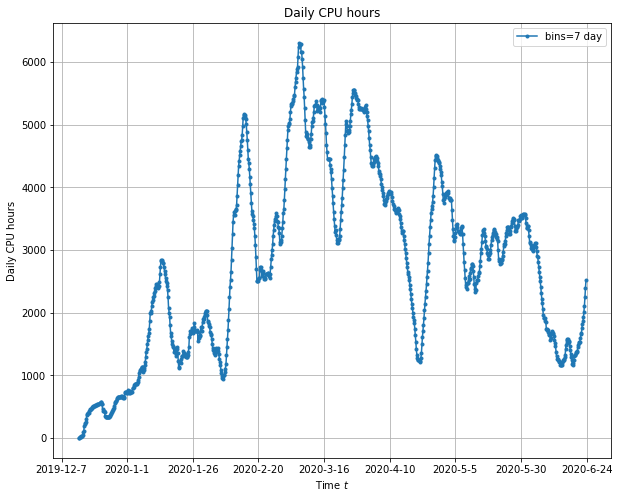

In [22]:
#my_ix = numpy.where(numpy.random.random(len(sacct_mazama.jobs_summary))>.75)
my_weekly_hours = sacct_mazama.get_cpu_hours(bin_size=7, n_points=1000, IX=None)
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(my_weekly_hours['time'], my_weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
#ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

#ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)

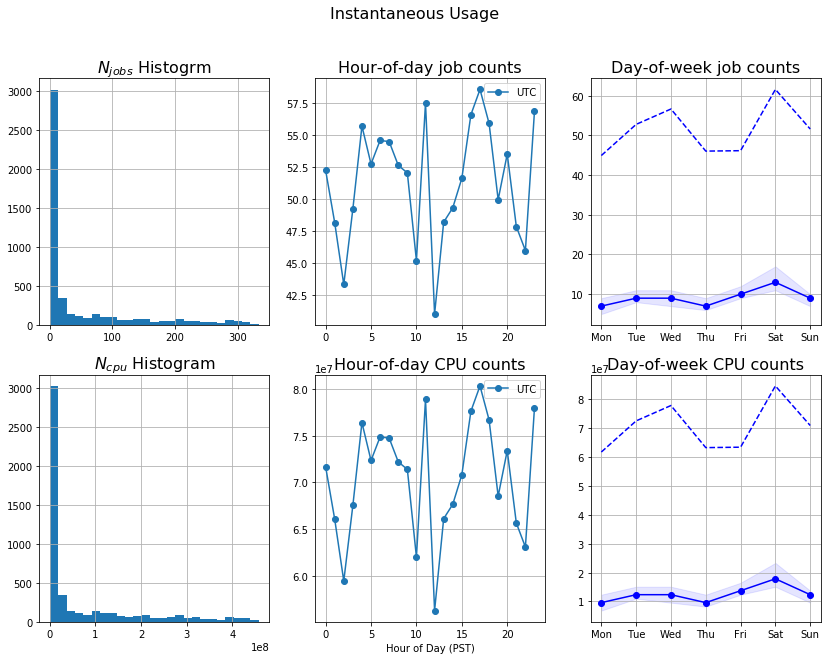

In [26]:
inst_stats = sacct_mazama.active_cpu_jobs_per_day_hour_report()
plt.savefig('{}/figs/jobs_per_{}_all.png'.format(output_path, system_name))

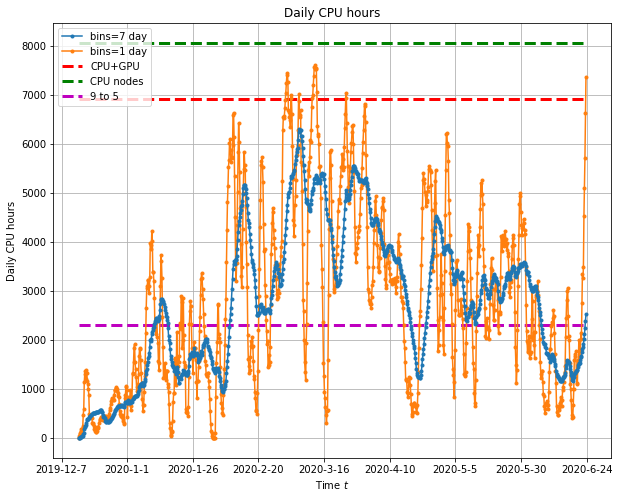

In [47]:
weekly_hours = sacct_mazama.get_cpu_hours(bin_size=7, n_points=1000)

daily_hours = sacct_mazama.get_cpu_hours(bin_size=1, n_points=1000)

fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

#ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)
ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*12*24*24, ls='--', marker='',
         lw=3., color='r', label='CPU+GPU')
ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*14*24*24, ls='--', marker='',
         lw=3., color='g', label='CPU nodes')
ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*12*24*8, ls='--', marker='',
         lw=3., color='m',label='9 to 5')
#
ax1.legend(loc=0)
if not os.path.isdir(os.path.join(output_path, 'figs')):
    os.makedirs(os.path.join(output_path, 'figs'))
plt.savefig(os.path.join(output_path, 'figs', 'daily_cpu_hours_all.png'))

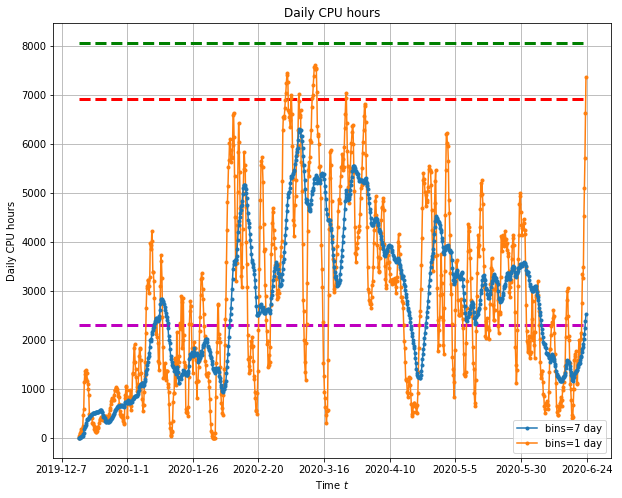

In [46]:
# weekly_hours_LL = sacct_mazama.get_cpu_hours_LL(bin_size=7, n_points=1000)
# daily_hours_LL = sacct_mazama.get_cpu_hours_LL(bin_size=1, n_points=1000)

# fg = plt.figure(figsize=(10,8))
# ax1 = plt.gca()
# ax1.grid()
# #
# ax1.plot(weekly_hours_LL['time'], weekly_hours_LL['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
# ax1.plot(daily_hours_LL['time'], daily_hours_LL['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


# #
# fg.canvas.draw()
# #
# # set ax3 labels to dates:
# # now format the datestrings...
# lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
# #print('*** ', lbls)
# #
# ax1.set_xticklabels(lbls)
# ax1.set_xlabel('Time $t$')
# ax1.set_ylabel('Daily CPU hours')
# ax1.set_title('Daily CPU hours')
# #
# ax1.legend(loc=0)

# #ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)
# ax1.plot(daily_hours['time'][0::len(daily_hours_LL)-1], numpy.ones(2)*12*24*24, ls='--', marker='',
#          lw=3., color='r', label='CPU+GPU')
# ax1.plot(daily_hours['time'][0::len(daily_hours_LL)-1], numpy.ones(2)*14*24*24, ls='--', marker='',
#          lw=3., color='g', label='CPU nodes')
# ax1.plot(daily_hours['time'][0::len(daily_hours_LL)-1], numpy.ones(2)*12*24*8, ls='--', marker='',
#          lw=3., color='m',label='9 to 5')

# # ax1.legend(loc=0)


# # if not os.path.isdir(os.path.join(output_path, 'figs')):
# #     os.makedirs(os.path.join(output_path, 'figs'))
# # plt.savefig(os.path.join(output_path, 'figs', 'daily_cpu_hours_all.png'))

In [33]:
# how many active nodes do we have? looks like tasks/cpus show up as 1/thread, so 48 per node, so...
n_max = numpy.max(daily_hours['cpu_hours'])
#
n_nodes = n_max/(24.*48.)
#
print('*** n_max={}, n_nodes={}'.format(n_max, n_nodes))
#140000/(24*48)

*** n_max=7615.170654133894, n_nodes=6.610391192824561


In [ ]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = sacct_mazama.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = sacct_mazama.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

In [ ]:
zz = sacct_mazama.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .55],
                                        figsize=(14,10), cpu_usage=None)

In [ ]:
# compute some distributions:
print('*** ', sacct_mazama.jobs_summary.dtype.names)
run_times = sacct_mazama.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
#ax1a.set_yscale('log')
ax3 = fg.add_subplot('223')
ax4 = fg.add_subplot('224')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, normed=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, normed=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True)
hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [ ]:
print('** ', len(run_times), len(sacct_mazama.jobs_summary['NCPUS']))

In [ ]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(sacct_mazama.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


In [ ]:
wait_stats = sacct_mazama.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')

In [ ]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


### Group drill-down stats: Example
- Demo of how to get some sort of PI/group subsets.
- More to come...

** DEBUG: sum(ix=119)
** DEBUG: shapes:: (119,), (119,)
***  ['2019-12-7', '2019-12-27', '2020-1-16', '2020-2-5', '2020-2-25', '2020-3-16', '2020-4-5', '2020-4-25', '2020-5-15', '2020-6-4']


[Text(737400.0, 0, '2019-12-7'),
 Text(737420.0, 0, '2019-12-27'),
 Text(737440.0, 0, '2020-1-16'),
 Text(737460.0, 0, '2020-2-5'),
 Text(737480.0, 0, '2020-2-25'),
 Text(737500.0, 0, '2020-3-16'),
 Text(737520.0, 0, '2020-4-5'),
 Text(737540.0, 0, '2020-4-25'),
 Text(737560.0, 0, '2020-5-15'),
 Text(737580.0, 0, '2020-6-4')]

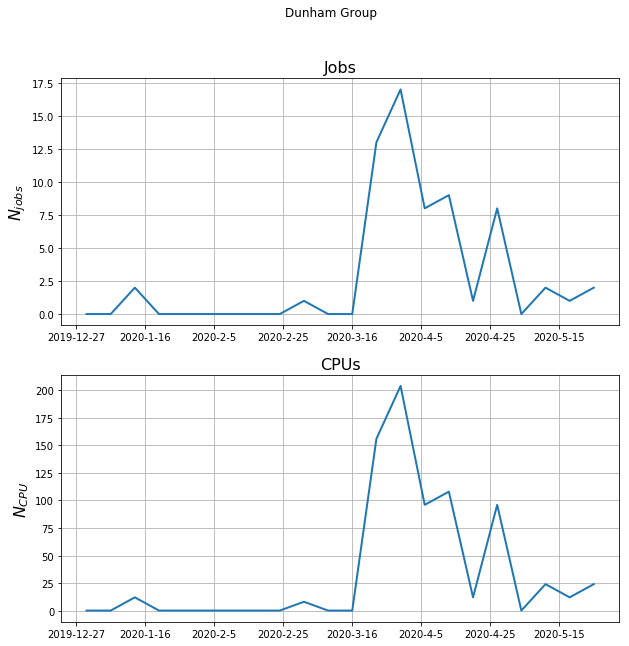

In [29]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in sacct_mazama.jobs_summary['User'] ])
#ix = numpy.array([True for s in sacct_mazama.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
print('** DEBUG: sum(ix={})'.format(numpy.sum(ix)))
#
cpu_weekly_edg = sacct_mazama.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly_edg['time'], cpu_weekly_edg['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly_edg['time'], cpu_weekly_edg['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

In [282]:
A = [['a', 'b', 'c'], ['d', 'e'], ['f', 'g', 'h', 'i']]
print(A)
AA = [s for rw in A for s in rw]
#
print('** AA: ', AA)

[['a', 'b', 'c'], ['d', 'e'], ['f', 'g', 'h', 'i']]
** AA:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']


### All the groups:

keys:  dict_keys(['header', 'title'])
keys:  dict_keys(['All'])
** DEBUG: shapes:: (1222496,), (1222496,)
*** Slide_1 added??::  3
*** Slide_2 added??::  4
** adding slide: slide_2
** adding slide: slide_3


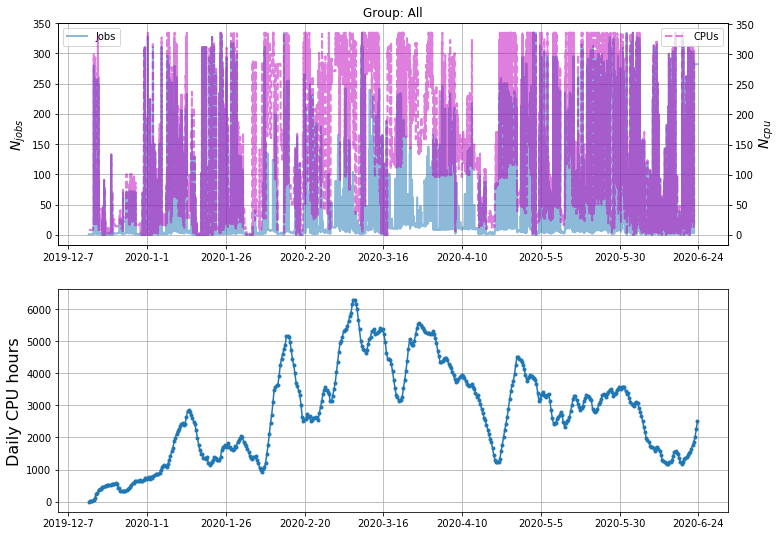

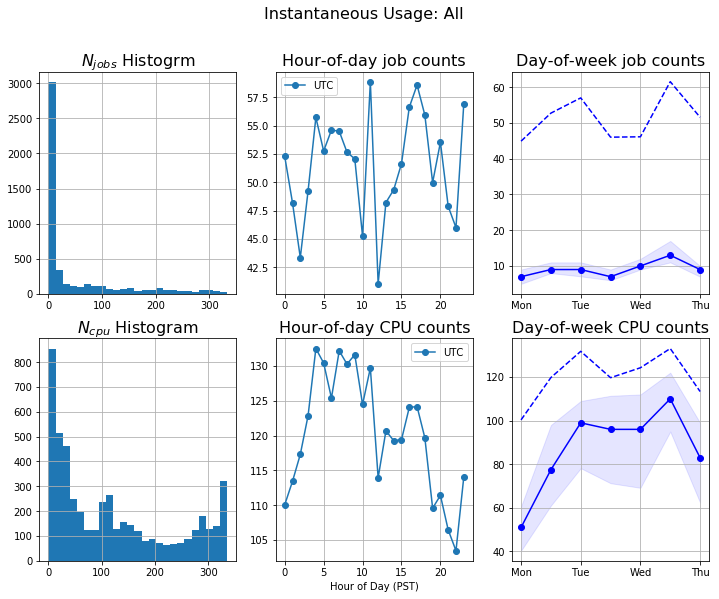

In [47]:
# make some slides, including all the breakdown.
# TODO: wrap this up into a class or function in HPC_lib.
# inputs: SACCT_data_handler object, groups-dict/JSON,  output_path, cosmetics (like line width, etc.)
#
add_all = True
#
if not os.path.isdir(os.path.join(output_path, 'figs')):
    os.makedirs(os.path.join(output_path, 'figs'))

# HPC_tex_obj = hpc_lib.Tex_Slides(Short_title='HPC Analytics', Full_title="HPC Analitics Breakdown for Mazama",
#                         foutname='output/HPC_analytics/HPC_analytics.tex')
HPC_tex_obj = hpc_lib.Tex_Slides(Short_title='HPC Analytics', Full_title="HPC Analitics Breakdown for Mazama",
                        foutname=os.path.join(output_path, 'HPC_analytics.tex') )


#
fig_width=".8"
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All): Daily CPU Hours',
#                                         width=fig_width, fig_path='figs/daily_cpu_hours_all.png')
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All): CPU/Jobs per day/hour', width=fig_width,
#                           fig_path='figs/jobs_per_mazama_all.png')
# print('*** ***')
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All)-2',
#                                         width=fig_width, fig_path='figs/daily_cpu_hours_all.png')

# print('*** * ***')
# HPC_tex_obj.add_fig_slide(fig_title='Mazama (All)-3',
#                                         width=fig_width, fig_path='figs/daily_cpu_hours_all.png')
# #
print('keys: ', HPC_tex_obj.project_tex.keys())

#HPC_tex_obj.render()

# Start with a table of weekly usage by group?
#
if groups_fname is None:
    groups={}
    groups['All'] = list(set(sacct_mazama.jobs_summary['User']))
else:
    with open(groups_fname, 'r') as fin:
        groups = json.load(fin)
    #
    if add_all and not "all" in [s.lower() for s in groups.keys()]:
        groups['All'] = list(set([s for rw in groups.values() for s in rw]))

print('keys: ', groups.keys() )
fig_size=tuple((12,9))
for k, (ky,usrs) in enumerate(groups.items()):
    #
    # tex corrected group name:
    grp_tex = ky.replace('_', '\_')
    gpr_tex = ky.replace('\\_', '\_')
    #
    ix = numpy.where([s in usrs for s in sacct_mazama.jobs_summary['User'] ])
    #print('** DEBUG: sum(ix)={} / ix.shape={}'.format(numpy.sum(ix), numpy.shape(ix)) )
    if len(ix)==0:
        print('[{}]:: no records.'.format(ky))
        continue
    #
    #
    #js_sub = numpy.array([tuple(rw) for rw in sacct_mazama.jobs_summary[ix]],
    #                                      dtype=sacct_mazama.jobs_summary.dtype)
    #print('*** js_sub: ', js_sub.shape, js_sub[0:3])
    #
    # this might actually work as intended. now. there were an odd combination of mistakes
    #. causing unpredictable behavior.
    wkly_hrs = sacct_mazama.get_cpu_hours(bin_size=7, n_points=500, IX=ix, verbose=0)
    #
    act_jobs = sacct_mazama.active_jobs_cpu(bin_size=None, t_min=None, ix=ix, verbose=0)
    if len(act_jobs)==0:
        print('Group: {}:: no records.'.format(ky))
        continue
    #
    fg = plt.figure(figsize=fig_size)
    ax1 = plt.subplot('211')
    ax1.grid()
    ax1a = ax1.twinx()
    ax2 = plt.subplot('212', sharex=ax1)
    ax2.grid()
    #
    ax1.plot(act_jobs['time'], act_jobs['N_jobs'], ls='-', lw=2., marker='', label='Jobs', alpha=.5 )
    ax1a.plot(act_jobs['time'], act_jobs['N_cpu'], ls='--', lw=2., marker='', color='m',
              label='CPUs', alpha=.5)
    ax1a.set_title('Group: {}'.format(ky))
    #
    ax2.plot(wkly_hrs['time'], wkly_hrs['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
    #
    ax1.set_ylabel('$N_{jobs}$', size=14)
    ax1a.set_ylabel('$N_{cpu}$', size=14)
    #
    ax1.legend(loc='upper left')
    ax1a.legend(loc='upper right')
    #
    ax2.set_ylabel('Daily CPU hours', size=16)
    #
    fg.canvas.draw()
    #
    # set ax3 labels to dates:
    # now format the datestrings...
    for ax in (ax1,):
        lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax.get_xticklabels()]
        ax.set_xticklabels(lbls)
    #    
    #
    # Save figure and add slide:
    cpu_usage_fig_name=os.path.join('figs', '{}_cpu_usage.png'.format(ky))
    cpu_usage_fig_path=os.path.join(output_path, cpu_usage_fig_name)
    plt.savefig(cpu_usage_fig_path)
    HPC_tex_obj.add_fig_slide(fig_title='{}: CPU/Jobs Requests'.format(grp_tex),
                                        width=fig_width, fig_path=cpu_usage_fig_name)
    print('*** Slide_1 added??:: ', len(HPC_tex_obj.project_tex))
              
    #
    # now, add the active jobs report:
    #jobs_per_name=os.path.join('figs', '{}_jobs_per.png'.format(ky))
    #jobs_per_path=os.path.join(output_path, jobs_per_name)
    #
    zz = sacct_mazama.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .55],
                                        figsize=fig_size, cpu_usage=act_jobs,foutname=None)
    plt.suptitle('Instantaneous Usage: {}'.format(ky), size=16)
    #
    #
    jobs_per_name=os.path.join('figs', '{}_jobs_per.png'.format(ky))
    jobs_per_path=os.path.join(output_path, jobs_per_name)
    #
    plt.savefig(jobs_per_path)
    HPC_tex_obj.add_fig_slide(fig_title='{}: Periodic Usage'.format(grp_tex),
                                        width=fig_width, fig_path=jobs_per_name)
    #
    print('*** Slide_2 added??:: ', len(HPC_tex_obj.project_tex))
    #
    #if k>2: break
    #HPC_tex_obj.render()
    #
HPC_tex_obj.render()

In [44]:
print(sacct_mazama.jobs_summary['End'].shape)
xx = sacct_mazama.jobs_summary['End']
print('** ', xx.shape, numpy.ndim(xx))
print('** ** ', xx[numpy.array([0,1,4,45,89,100])].shape)

(1381096,)
**  (1381096,) 1
** **  (6,)


In [ ]:
if True:
    with open(data_file_name, 'r') as fin:
        header_rw = fin.readline()
        print('*** ', header_rw)

    headers = header_rw.split('|')
    k_group = headers.index('Group')
    k_gid = headers.index('GID')
    #
    
    with open(data_file_name, 'r') as fin:
        for k,rw in enumerate(fin):
            #if 'dunham' in rw: print('** ', rw)
            #if 'dunham' in rw:
            #    rws = rw.split('|')
            #    print('** ', rws[k_group], rws[k_gid])
            if 'Partition_Limit' in rw:
                print('** ', rw)
                k+=1
                if k>10: break



In [ ]:
for rw in zip([1,2,3,4], [5,6,7,8], [9,10,11, 12]):
    print('* ', rw)

In [ ]:
A = numpy.array(numpy.zeros((10,3)), dtype=[('x', '>f8'), ('y', '>f8'), ('z', '>f8')])
print('A ', A)

In [170]:
# print('** \n', my_tex_obj.get_fig_slide(fig_title='Mazama (All)',
#                                         width=.8, fig_path='{}/daily_cpu_hours_all.png'.format(output_path)))

** 
 \begin{frame}
\frametitle{Mazama (All)}
%Uncomment the code on this slide to include your own image from the same directory as the template .TeX file.
\begin{figure}
\includegraphics[width={0.8}\linewidth]{output/HPC_analytics/daily_cpu_hours_all.png}
\end{figure}
\end{frame}



*** cleaning up old out_path...
*** out_path (should be) removed:  CompletedProcess(args=['rm', '-rf', 'output/SERC_HPC_analytics'], returncode=0)
keys:  dict_keys(['All'])
*** DEBUG: group: All
** DEBUG: shapes:: (1222496,), (1222496,)
*** [All] Slide_1 added??:: 3
*** Slide_2 added??::  4
** adding slide: slide_2
** adding slide: slide_3


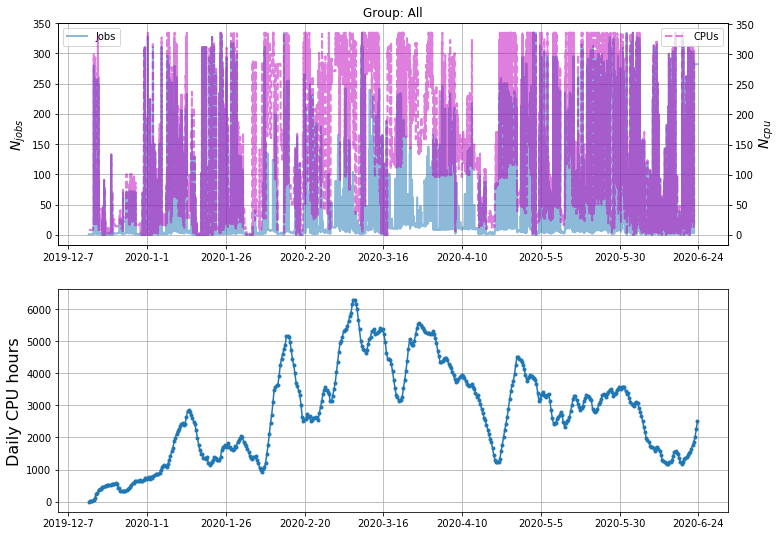

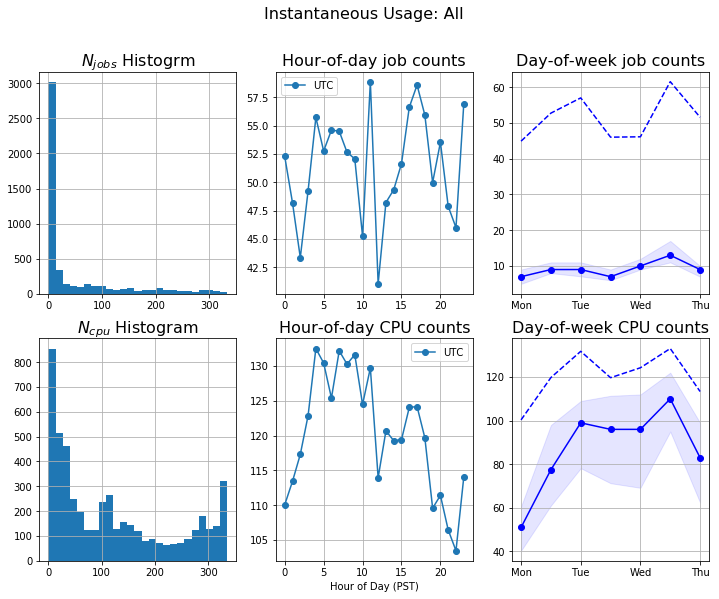

In [50]:
#out_path = 'output/mazama_analytics'
print('*** cleaning up old out_path...')
sp_status = subprocess.run(['rm', '-rf', output_path])
print('*** out_path (should be) removed: ', sp_status)
#
mazama_report = hpc_lib.SACCT_groups_analyzer_report(out_path=output_path, groups=groups_fname,
                                            tex_filename='Mazama_HPC_analytics.tex',
                                            SACCT_obj=sacct_mazama, max_rws=None)

In [31]:
print('** ', sacct_mazama.jobs_summary.dtype.names)


**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'ReqTRES', 'AllocTRES', 'JobID_parent')


In [32]:
print('** ', sacct_mazama.jobs_summary['AllocGRES'][0:100] )

**  [None 'gpu:2' None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None]


In [33]:
sacct_mazama.jobs_summary.dtype.names

('index',
 'User',
 'Group',
 'GID',
 'JobName',
 'JobID',
 'JobIDRaw',
 'Partition',
 'State',
 'Timelimit',
 'NCPUS',
 'NNodes',
 'Submit',
 'Eligible',
 'Start',
 'End',
 'Elapsed',
 'SystemCPU',
 'UserCPU',
 'TotalCPU',
 'NTasks',
 'CPUTimeRAW',
 'Suspended',
 'ReqGRES',
 'AllocGRES',
 'ReqTRES',
 'AllocTRES',
 'JobID_parent')